In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### LOAD DATASET

In [3]:
df = pd.read_csv("../data/atp_tennis.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66613 entries, 0 to 66612
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tournament  66613 non-null  object 
 1   Date        66613 non-null  object 
 2   Series      66613 non-null  object 
 3   Court       66613 non-null  object 
 4   Surface     66613 non-null  object 
 5   Round       66613 non-null  object 
 6   Best of     66613 non-null  int64  
 7   Player_1    66613 non-null  object 
 8   Player_2    66613 non-null  object 
 9   Winner      66613 non-null  object 
 10  Rank_1      66613 non-null  int64  
 11  Rank_2      66613 non-null  int64  
 12  Pts_1       66613 non-null  int64  
 13  Pts_2       66613 non-null  int64  
 14  Odd_1       66613 non-null  float64
 15  Odd_2       66613 non-null  float64
 16  Score       66613 non-null  object 
dtypes: float64(2), int64(5), object(10)
memory usage: 8.6+ MB


In [5]:
df['Series'].value_counts()

Series
ATP250                17636
Grand Slam            12512
International         11752
Masters 1000           9221
ATP500                 6471
Masters                5029
International Gold     3620
Masters Cup             372
Name: count, dtype: int64

In [6]:
df.tail(8)

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score
66605,BNP Paribas Masters,2025-10-30,Masters 1000,Indoor,Hard,3rd Round,3,Davidovich Fokina A.,Zverev A.,Zverev A.,15,3,2585,6160,2.75,1.44,2-6 4-6
66606,BNP Paribas Masters,2025-10-31,Masters 1000,Indoor,Hard,Quarterfinals,3,Auger-Aliassime F.,Vacherot V.,Auger-Aliassime F.,10,40,3195,1283,1.57,2.38,6-2 6-2
66607,BNP Paribas Masters,2025-10-31,Masters 1000,Indoor,Hard,Quarterfinals,3,De Minaur A.,Bublik A.,Bublik A.,6,16,3935,2520,1.73,2.10,7-6 4-6 5-7
66608,BNP Paribas Masters,2025-10-31,Masters 1000,Indoor,Hard,Quarterfinals,3,Sinner J.,Shelton B.,Sinner J.,2,7,10500,3820,1.17,5.00,6-3 6-3
66609,BNP Paribas Masters,2025-10-31,Masters 1000,Indoor,Hard,Quarterfinals,3,Medvedev D.,Zverev A.,Zverev A.,13,3,2810,6160,1.73,2.10,6-2 3-6 6-7
66610,BNP Paribas Masters,2025-11-01,Masters 1000,Indoor,Hard,Semifinals,3,Auger-Aliassime F.,Bublik A.,Auger-Aliassime F.,10,16,3195,2520,1.91,1.91,7-6 6-4
66611,BNP Paribas Masters,2025-11-01,Masters 1000,Indoor,Hard,Semifinals,3,Zverev A.,Sinner J.,Sinner J.,3,2,6160,10500,6.00,1.13,0-6 1-6
66612,BNP Paribas Masters,2025-11-02,Masters 1000,Indoor,Hard,The Final,3,Sinner J.,Auger-Aliassime F.,Sinner J.,2,10,10500,3195,1.10,7.00,6-4 7-6


In [7]:
df.tail(10)

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score
66603,BNP Paribas Masters,2025-10-30,Masters 1000,Indoor,Hard,3rd Round,3,Sonego L.,Medvedev D.,Medvedev D.,45,13,1130,2810,4.50,1.20,6-3 6-7 4-6
66604,BNP Paribas Masters,2025-10-30,Masters 1000,Indoor,Hard,3rd Round,3,Sinner J.,Cerundolo F.,Sinner J.,2,21,10500,2085,1.04,13.00,7-5 6-1
66605,BNP Paribas Masters,2025-10-30,Masters 1000,Indoor,Hard,3rd Round,3,Davidovich Fokina A.,Zverev A.,Zverev A.,15,3,2585,6160,2.75,1.44,2-6 4-6
66606,BNP Paribas Masters,2025-10-31,Masters 1000,Indoor,Hard,Quarterfinals,3,Auger-Aliassime F.,Vacherot V.,Auger-Aliassime F.,10,40,3195,1283,1.57,2.38,6-2 6-2
66607,BNP Paribas Masters,2025-10-31,Masters 1000,Indoor,Hard,Quarterfinals,3,De Minaur A.,Bublik A.,Bublik A.,6,16,3935,2520,1.73,2.10,7-6 4-6 5-7
66608,BNP Paribas Masters,2025-10-31,Masters 1000,Indoor,Hard,Quarterfinals,3,Sinner J.,Shelton B.,Sinner J.,2,7,10500,3820,1.17,5.00,6-3 6-3
66609,BNP Paribas Masters,2025-10-31,Masters 1000,Indoor,Hard,Quarterfinals,3,Medvedev D.,Zverev A.,Zverev A.,13,3,2810,6160,1.73,2.10,6-2 3-6 6-7
66610,BNP Paribas Masters,2025-11-01,Masters 1000,Indoor,Hard,Semifinals,3,Auger-Aliassime F.,Bublik A.,Auger-Aliassime F.,10,16,3195,2520,1.91,1.91,7-6 6-4
66611,BNP Paribas Masters,2025-11-01,Masters 1000,Indoor,Hard,Semifinals,3,Zverev A.,Sinner J.,Sinner J.,3,2,6160,10500,6.00,1.13,0-6 1-6
66612,BNP Paribas Masters,2025-11-02,Masters 1000,Indoor,Hard,The Final,3,Sinner J.,Auger-Aliassime F.,Sinner J.,2,10,10500,3195,1.10,7.00,6-4 7-6


### FILTER DATA FOR LAST 2 YEARS

In [8]:
# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [9]:
# Remove rows with missing essential information
df = df.dropna(subset=["Player_1", "Player_2", "Winner", "Rank_1", "Rank_2", "Odd_1", "Odd_2"])

In [10]:
# Filter for last 2 years
df = df[df["Date"] >= pd.Timestamp.now() - pd.DateOffset(years=2)].reset_index(drop=True)

In [11]:
df['Series'].value_counts()

Series
ATP250          1847
Masters 1000    1411
Grand Slam       965
ATP500           868
Masters Cup       29
Name: count, dtype: int64

### REMOVE TARGET TOURNAMENT (QUARTERFINALS ONWARDS)

In [12]:
mask_target_tournament = (
    (df['Tournament'].str.contains('BNP Paribas Masters', case=False, na=False)) &
    (df['Round'].str.contains('Quarterfinals|Semifinals|Final', case=False, na=False)) &
    (df['Date'].dt.year == 2025)
)

In [13]:
matches_to_predict = df[mask_target_tournament].copy()
print(f"\nMatches separated for prediction: {len(matches_to_predict)}")
print(matches_to_predict[['Date', 'Player_1', 'Player_2', 'Round']].to_string())


Matches separated for prediction: 7
           Date            Player_1            Player_2          Round
5113 2025-10-31  Auger-Aliassime F.         Vacherot V.  Quarterfinals
5114 2025-10-31        De Minaur A.           Bublik A.  Quarterfinals
5115 2025-10-31           Sinner J.          Shelton B.  Quarterfinals
5116 2025-10-31         Medvedev D.           Zverev A.  Quarterfinals
5117 2025-11-01  Auger-Aliassime F.           Bublik A.     Semifinals
5118 2025-11-01           Zverev A.           Sinner J.     Semifinals
5119 2025-11-02           Sinner J.  Auger-Aliassime F.      The Final


In [14]:
# Remove from main dataset
df_train = df[~mask_target_tournament].copy()
print(f"\nTraining dataset: {len(df_train)} matches\n")


Training dataset: 5113 matches



### CREATE BASIC FEATURES

In [15]:
# Ranking difference
df_train["Rank_diff"] = df_train['Rank_1'] - df_train['Rank_2']
df_train["Pts_diff"] = df_train['Pts_1'] - df_train['Pts_2']

In [16]:
# Implied probability from odds
df_train["Prob_1"] = 1 / df_train['Odd_1']
df_train["Prob_2"] = 1 / df_train['Odd_2']
df_train["Prob_diff"] = df_train['Prob_1'] - df_train['Prob_2']

In [17]:
# Target variable (1 if Player_1 won, 0 otherwise)
df_train['Target'] = (df_train['Winner'] == df_train['Player_1']).astype(int)

### CREATE WEIGHTED WIN RATE AND H2H

In [18]:
def weighted_win_rate(player, current_date, df, years=2):
    """
    Calculate weighted win rate using only previous matches
    More recent matches have higher weight
    """
    # Filter previous matches within 2-year window
    mask = (df["Date"] < current_date) & (
        (df["Player_1"] == player) | (df['Player_2'] == player)
    )
    past_matches = df.loc[mask]
    
    if past_matches.empty:
        return np.nan
    
    # Calculate if the player won
    past_matches["Win"] = np.where(past_matches['Winner'] == player, 1, 0)
    
    # Calculate time-based weight (more recent = higher weight)
    past_matches["Days_diff"] = (current_date - past_matches['Date']).dt.days
    past_matches["weight"] = np.exp(-past_matches["Days_diff"] / 365)  # Decays each year
    
    # Weighted win rate
    win_rate = np.average(past_matches["Win"], weights=past_matches["weight"])
    return win_rate

In [19]:
def weighted_h2h(player1, player2, current_date, df, years=2):
    """
    Calculate weighted head-to-head using only previous matches
    More recent matches have higher weight
    """
    # Filter direct confrontations within 2-year window
    mask = (df['Date'] < current_date) & (
        ((df['Player_1'] == player1) & (df['Player_2'] == player2)) |
        ((df['Player_1'] == player2) & (df['Player_2'] == player1))
    )
    h2h_matches = df.loc[mask]
    
    if h2h_matches.empty:
        return np.nan
    
    # Calculate if player1 won
    h2h_matches["Win"] = np.where(h2h_matches['Winner'] == player1, 1, 0)
    h2h_matches["Days_diff"] = (current_date - h2h_matches["Date"]).dt.days
    h2h_matches["weight"] = np.exp(-h2h_matches["Days_diff"] / 365)
    
    h2h_score = np.average(h2h_matches["Win"], weights=h2h_matches["weight"])
    return h2h_score

In [20]:
# Apply functions to the dataset
df_train["Win_Rate_1"] = df_train.apply(
    lambda row: weighted_win_rate(row["Player_1"], row["Date"], df_train), axis=1
)
df_train["Win_Rate_2"] = df_train.apply(
    lambda row: weighted_win_rate(row["Player_2"], row["Date"], df_train), axis=1
)
df_train["H2H_1"] = df_train.apply(
    lambda row: weighted_h2h(row["Player_1"], row["Player_2"], row["Date"], df_train), axis=1
)

### SELECT AND NORMALIZE FEATURES

In [21]:
# Select most relevant features
features = [
    'Rank_diff',
    'Pts_diff',
    'Prob_diff',
    'Win_Rate_1',
    'Win_Rate_2',
    'H2H_1'
]

In [22]:
# Remove possible missing values
df_model = df_train.dropna(subset=features + ['Target'])

In [23]:
# Separate X (inputs) and y (output)
X = df_model[features]
y = df_model['Target']

In [24]:
# Split into train and test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### TRAIN MACHINE LEARNING MODEL

In [26]:
# Create and train the model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [27]:
# Make predictions on test set
y_pred = model.predict(X_test_scaled)

In [28]:
# Evaluate performance
print("Model Performance on Test Set")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Performance on Test Set
Accuracy: 0.7511

Confusion Matrix:
[[90 28]
 [28 79]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       118
           1       0.74      0.74      0.74       107

    accuracy                           0.75       225
   macro avg       0.75      0.75      0.75       225
weighted avg       0.75      0.75      0.75       225



### PREPARE TARGET TOURNAMENT DATA

In [ ]:
if len(matches_to_predict) > 0:
    # Create basic features
    matches_to_predict["Rank_diff"] = matches_to_predict['Rank_1'] - matches_to_predict['Rank_2']
    matches_to_predict["Pts_diff"] = matches_to_predict['Pts_1'] - matches_to_predict['Pts_2']
    matches_to_predict["Prob_1"] = 1 / matches_to_predict['Odd_1']
    matches_to_predict["Prob_2"] = 1 / matches_to_predict['Odd_2']
    matches_to_predict["Prob_diff"] = matches_to_predict['Prob_1'] - matches_to_predict['Prob_2']
    matches_to_predict['Target'] = (matches_to_predict['Winner'] == matches_to_predict['Player_1']).astype(int)
    
    matches_to_predict["Win_Rate_1"] = matches_to_predict.apply(
        lambda row: weighted_win_rate(row["Player_1"], row["Date"], df_train), axis=1
    )
    matches_to_predict["Win_Rate_2"] = matches_to_predict.apply(
        lambda row: weighted_win_rate(row["Player_2"], row["Date"], df_train), axis=1
    )
    matches_to_predict["H2H_1"] = matches_to_predict.apply(
        lambda row: weighted_h2h(row["Player_1"], row["Player_2"], row["Date"], df_train), axis=1
    )
    # Prepare features for prediction
    X_predict = matches_to_predict[features].fillna(0)
    X_predict_scaled = scaler.transform(X_predict)

### MAKE PREDICTIONS

In [30]:
matches_to_predict["Prob_Player1_Win"] = model.predict_proba(X_predict_scaled)[:, 1]
matches_to_predict["Pred_Winner"] = matches_to_predict.apply(
    lambda row: row["Player_1"] if row["Prob_Player1_Win"] > 0.5 else row["Player_2"],
    axis=1
)
print("\nPredictions - BNP Paribas Masters 2025\n")

for _, row in matches_to_predict.iterrows():
    prob = row["Prob_Player1_Win"] if row["Pred_Winner"] == row["Player_1"] else 1 - row["Prob_Player1_Win"]
    actual_result = "✓" if row["Pred_Winner"] == row["Winner"] else "✗"
    print(f"{actual_result} {row['Player_1']} vs {row['Player_2']}")
    print(f"  Predicted: {row['Pred_Winner']} ({prob * 100:.1f}%)")
    print(f"  Actual: {row['Winner']}\n")


Predictions - BNP Paribas Masters 2025

✓ Auger-Aliassime F. vs Vacherot V.
  Predicted: Auger-Aliassime F. (62.2%)
  Actual: Auger-Aliassime F.

✗ De Minaur A. vs Bublik A.
  Predicted: De Minaur A. (56.0%)
  Actual: Bublik A.

✓ Sinner J. vs Shelton B.
  Predicted: Sinner J. (85.5%)
  Actual: Sinner J.

✗ Medvedev D. vs Zverev A.
  Predicted: Medvedev D. (61.8%)
  Actual: Zverev A.

✓ Auger-Aliassime F. vs Bublik A.
  Predicted: Auger-Aliassime F. (52.7%)
  Actual: Auger-Aliassime F.

✓ Zverev A. vs Sinner J.
  Predicted: Sinner J. (81.1%)
  Actual: Sinner J.

✓ Sinner J. vs Auger-Aliassime F.
  Predicted: Sinner J. (88.4%)
  Actual: Sinner J.



In [31]:
# Accuracy on target tournament predictions
correct = (matches_to_predict["Pred_Winner"] == matches_to_predict["Winner"]).sum()
total = len(matches_to_predict)
print(f"Tournament Accuracy: {correct}/{total} ({correct/total*100:.1f}%)\n")

Tournament Accuracy: 5/7 (71.4%)



### ERROR ANALYSIS

In [32]:
errors = matches_to_predict[matches_to_predict["Pred_Winner"] != matches_to_predict["Winner"]].copy()

if len(errors) > 0:
    print("Error Analysis\n")
    
    cols = ["Date", "Player_1", "Player_2", "Rank_1", "Rank_2", 
            "Odd_1", "Odd_2", "Prob_Player1_Win", "Pred_Winner", "Winner",
            "Win_Rate_1", "Win_Rate_2", "H2H_1"]
    existing_cols = [c for c in cols if c in errors.columns]
    
    print(errors[existing_cols].to_string())

Error Analysis

           Date      Player_1   Player_2  Rank_1  Rank_2  Odd_1  Odd_2  Prob_Player1_Win   Pred_Winner     Winner  Win_Rate_1  Win_Rate_2     H2H_1
5114 2025-10-31  De Minaur A.  Bublik A.       6      16   1.73    2.1          0.560468  De Minaur A.  Bublik A.    0.713457    0.651078  0.228081
5116 2025-10-31   Medvedev D.  Zverev A.      13       3   1.73    2.1          0.618232   Medvedev D.  Zverev A.    0.679541    0.726115  1.000000


### CONFUSION MATRIX FOR TARGET TOURNAMENT


Confusion Matrix - Target Tournament
[[1 2]
 [0 4]]


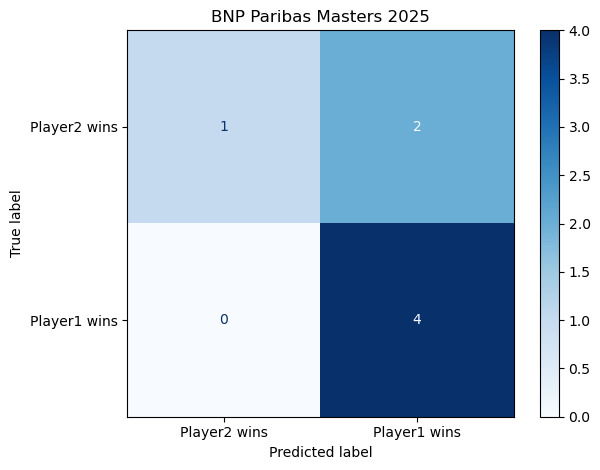

In [33]:
y_true_tournament = matches_to_predict["Target"]
y_pred_tournament = (matches_to_predict["Prob_Player1_Win"] > 0.5).astype(int)

cm = confusion_matrix(y_true_tournament, y_pred_tournament)

print("\nConfusion Matrix - Target Tournament")
print(cm)

disp = ConfusionMatrixDisplay(cm, display_labels=["Player2 wins", "Player1 wins"])
disp.plot(cmap='Blues')
plt.title("BNP Paribas Masters 2025")
plt.tight_layout()
plt.show()

### COMPARISON: MODEL VS MARKET

In [34]:
matches_to_predict["Market_Prob_Player1"] = 1 / matches_to_predict["Odd_1"]

print("\nModel vs Market Odds\n")
print(matches_to_predict[["Player_1", "Player_2", "Market_Prob_Player1", "Prob_Player1_Win", "Winner"]].to_string())


Model vs Market Odds

                Player_1            Player_2  Market_Prob_Player1  Prob_Player1_Win              Winner
5113  Auger-Aliassime F.         Vacherot V.             0.636943          0.622022  Auger-Aliassime F.
5114        De Minaur A.           Bublik A.             0.578035          0.560468           Bublik A.
5115           Sinner J.          Shelton B.             0.854701          0.854802           Sinner J.
5116         Medvedev D.           Zverev A.             0.578035          0.618232           Zverev A.
5117  Auger-Aliassime F.           Bublik A.             0.523560          0.527069  Auger-Aliassime F.
5118           Zverev A.           Sinner J.             0.166667          0.189099           Sinner J.
5119           Sinner J.  Auger-Aliassime F.             0.909091          0.883966           Sinner J.
